## Table of Contents

* [Import Libraries](#import-libraries)
* [Import Clean Train and Test Data with Dummies](#import-clean-train-and-test-data-with-dummies)
* [Exploratory Data Analysis (EDA) and Visualizations](#exploratory-data-analysis-(eda)-and-visualizations)
    * [Heatmaps](#heatmaps)
    * [Histogram and Pairplots](#histogram-and-pairplots)
* [TTS and Fit Model](#tts-and-fit-model)
    * [Model Prep](#model-prep)
    * [LINE Assumptions](#line-assumptions)
* [Score Model](#score-model)
    * [Statsmodel Library](#statsmodel-library)
* [Ridge and LASSO Model](#ridge-and-lasso-model)
    * [Polynomial Features](#polynomial-features)
    * [OLS](#ols)
    * [RidgeCV](#ridgecv)
    * [LASSOCV](#lassocv)
* [Visualizations](#visualizations)

# Import Libraries

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

# Import Clean Train and Test Data with Dummies

In [169]:
# load Training Data
train = pd.read_csv('./clean_datasets/finish_clean_training_dummified.csv')

# Load Testing Data
test = pd.read_csv('./clean_datasets/finish_clean_testing_dummified.csv')

In [170]:
train.shape

(2051, 207)

In [171]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Columns: 207 entries, id to sale_type_WD 
dtypes: float64(9), int64(194), object(4)
memory usage: 3.2+ MB


In [172]:
train.head()

,id,lot_frontage,lot_area,lot_shape,utilities,land_slope,overall_qual,overall_cond,year_built,year_remod/add,...,misc_feature_Shed,misc_feature_TenC,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD
0,109,0.0,13517,2,3,Gtl,6,8,1976,2005,...,0,0,0,0,0,0,0,0,0,1
1,544,43.0,11492,2,3,Gtl,7,5,1996,1997,...,0,0,0,0,0,0,0,0,0,1
2,153,68.0,7922,3,3,Gtl,5,7,1953,2007,...,0,0,0,0,0,0,0,0,0,1
3,318,73.0,9802,3,3,Gtl,5,5,2006,2007,...,0,0,0,0,0,0,0,0,0,1
4,255,82.0,14235,2,3,Gtl,6,8,1900,1993,...,0,0,0,0,0,0,0,0,0,1


In [173]:
test.shape

(878, 195)

# Exploratory Data Analysis (EDA) and Visualizations

## Heatmaps

C:\Users\Crypt\AppData\Local\Temp\ipykernel_18392\1044488063.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),


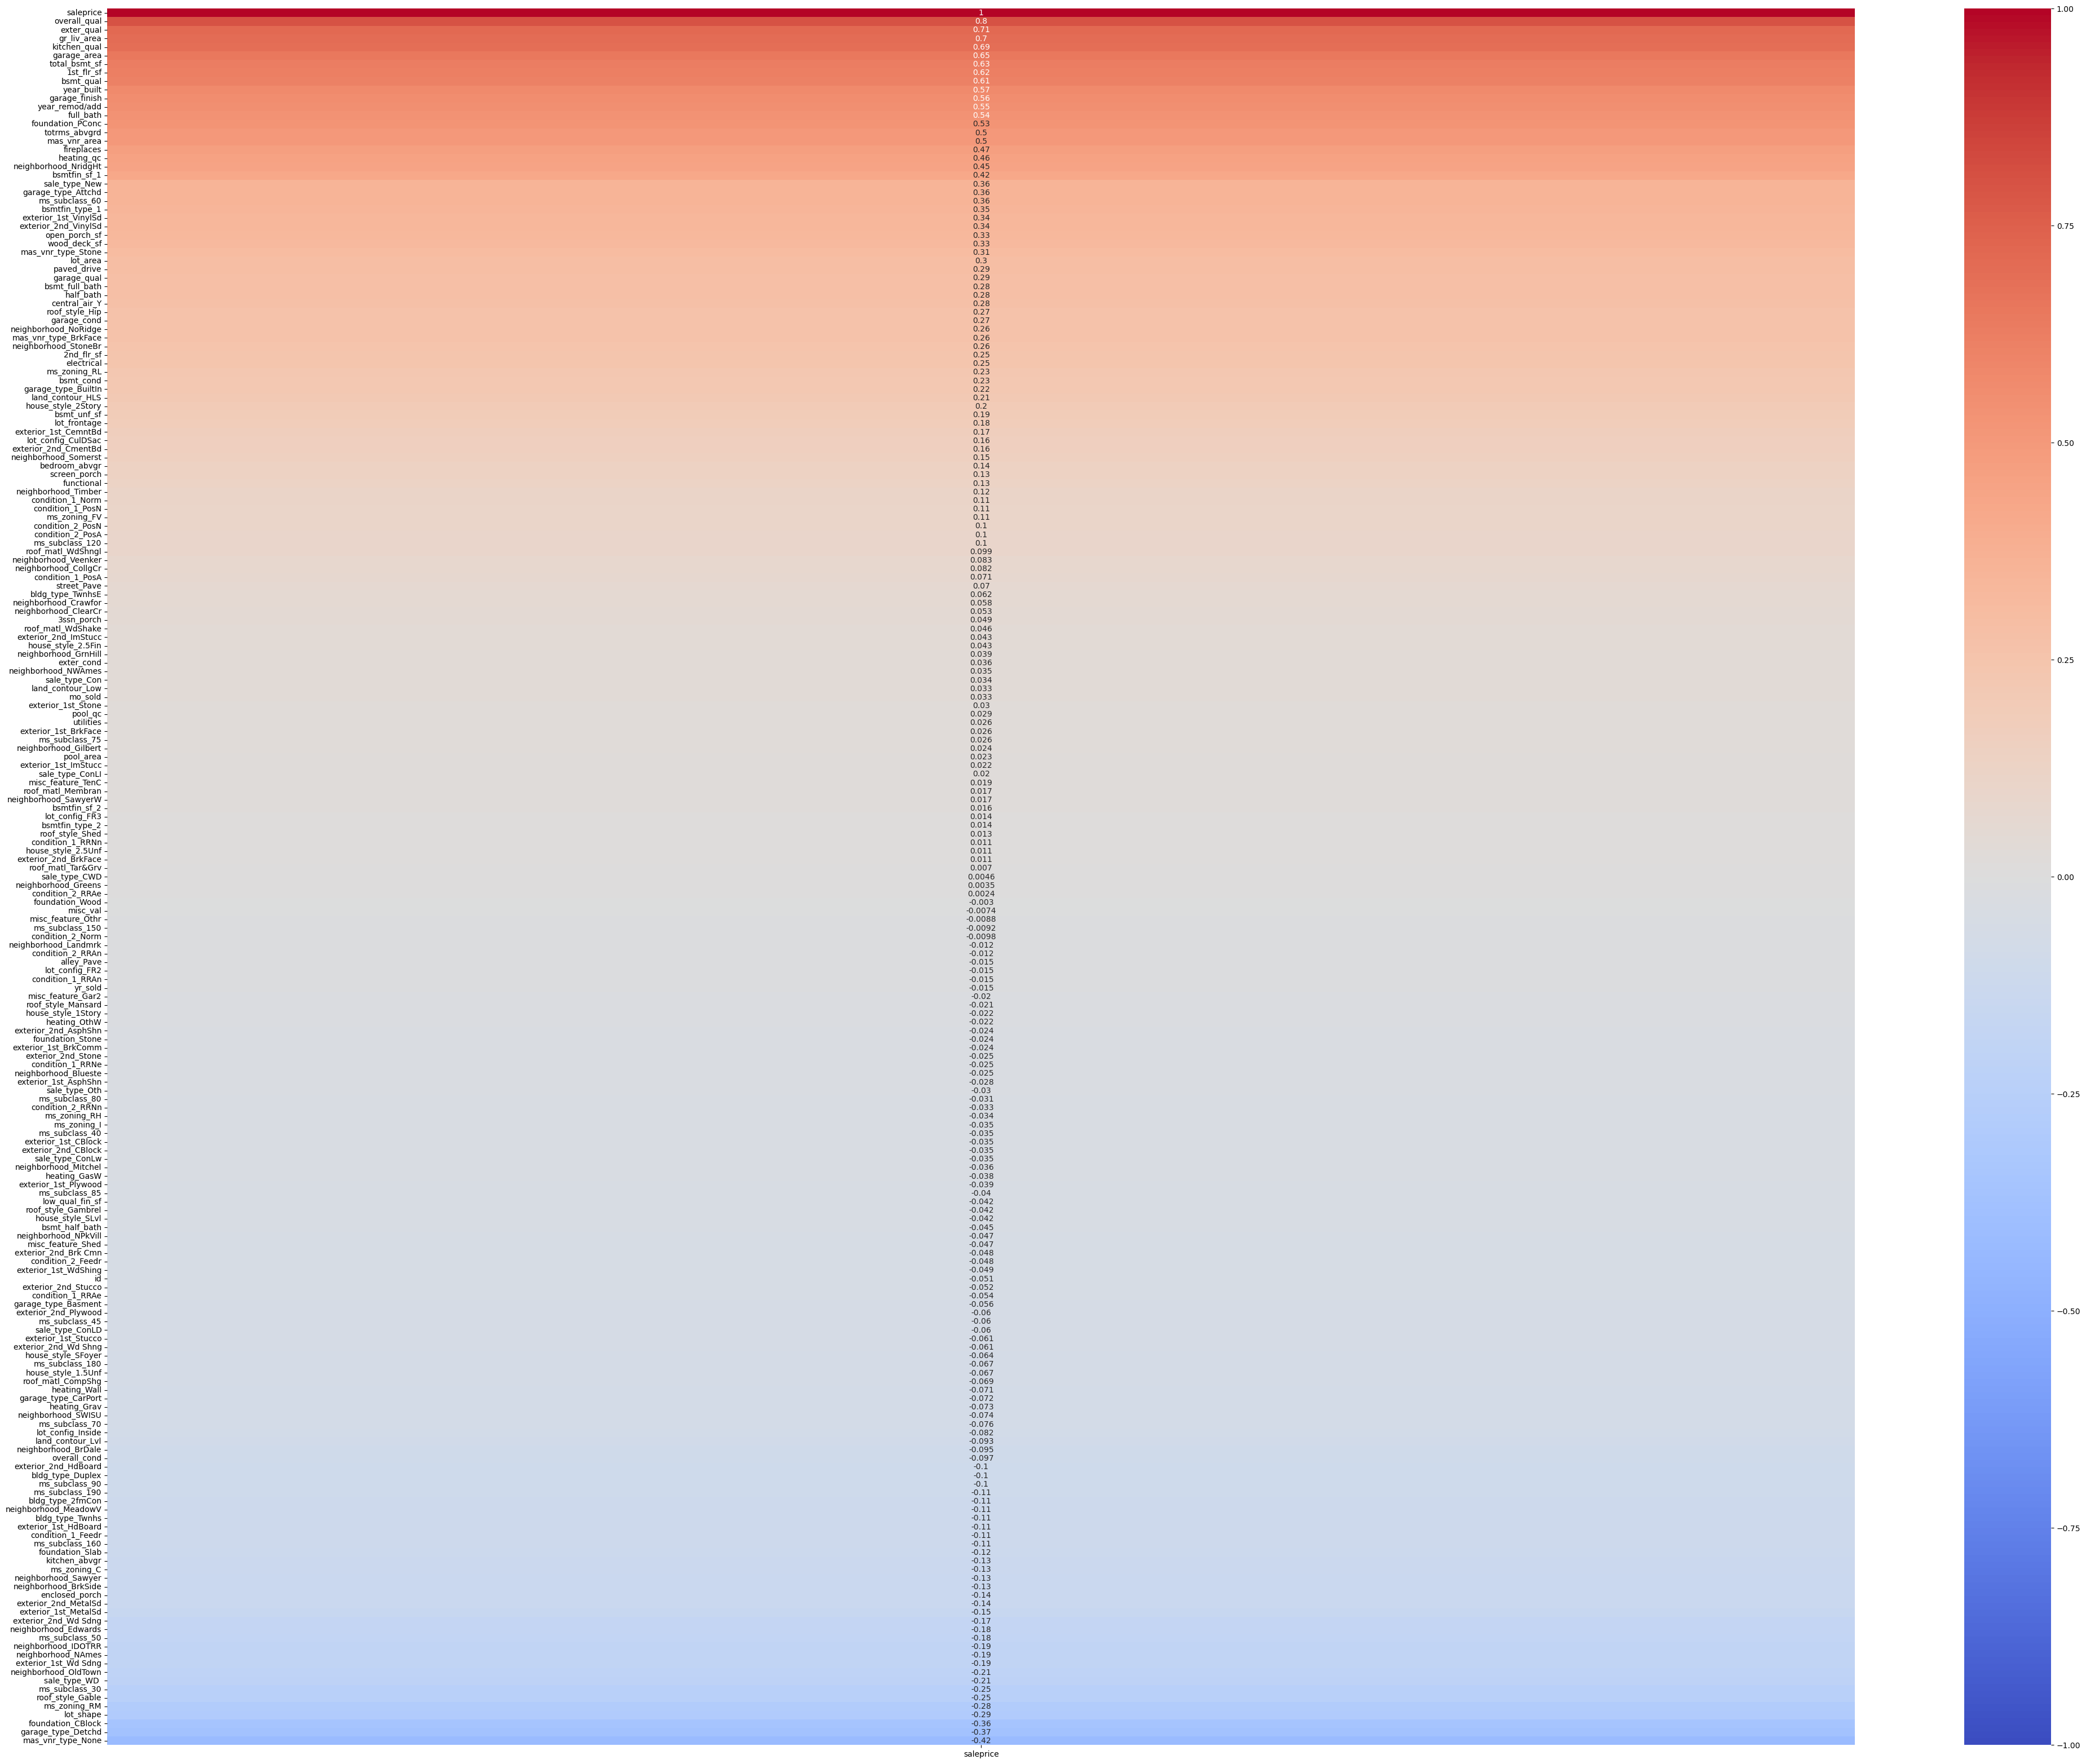

In [174]:
plt.figure(figsize=(50, 40))
sns.heatmap(train.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
            annot=True,
            vmin=-1,
            vmax=1,
            cmap='coolwarm',);

C:\Users\Crypt\AppData\Local\Temp\ipykernel_18392\2703748892.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = abs(train.corr()[['saleprice']])


Correlations below threshold:
                      saleprice
exterior_1st_WdShing   0.048866
3ssn_porch             0.048732
condition_2_Feedr      0.048455
exterior_2nd_Brk Cmn   0.047893
misc_feature_Shed      0.047419
...                         ...
roof_matl_Tar&Grv      0.007018
sale_type_CWD          0.004563
neighborhood_Greens    0.003476
foundation_Wood        0.003044
condition_2_RRAe       0.002378

[77 rows x 1 columns]


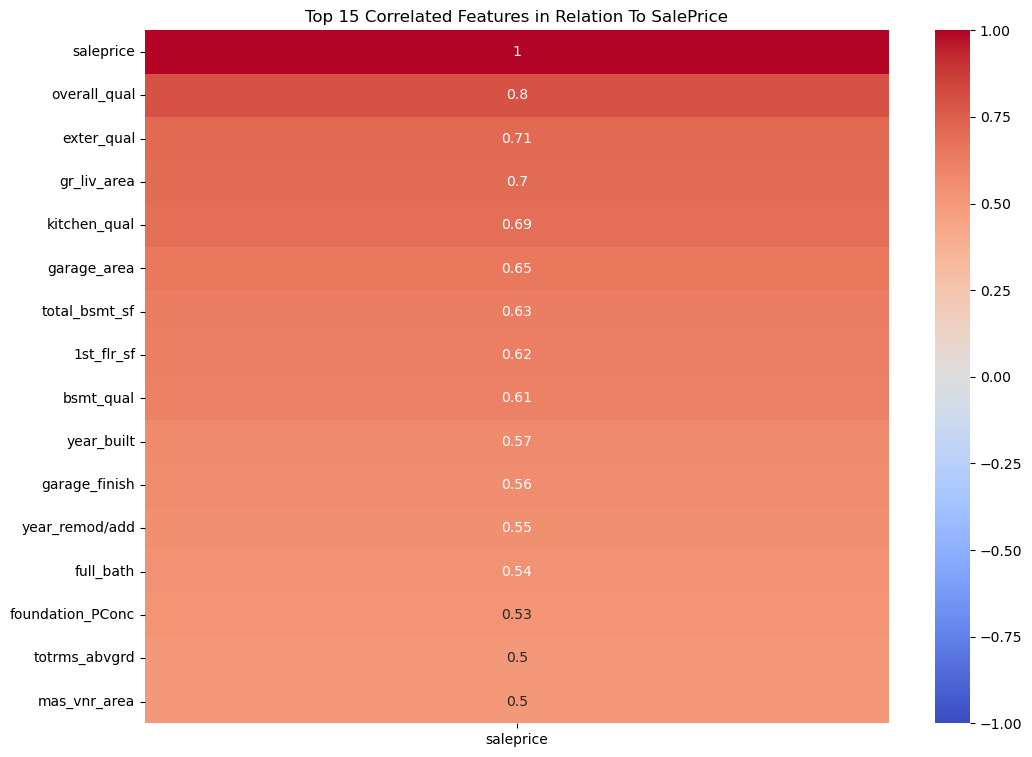

In [175]:
# Because there are over 200 columns, I will be looking at the top 15 correlations with a threshold of 5%

# Threshold for correlation for 'saleprice'
threshold = 0.05

# Top correlated with 'saleprice'
top_n = 16

# Absolute correlations with 'saleprice'
corr_matrix = abs(train.corr()[['saleprice']])
sorted_corr = corr_matrix.sort_values('saleprice', ascending=False)

# Filter the correlations that are below threshold
below_threshold_corr = sorted_corr.loc[sorted_corr['saleprice'] < threshold]

# Top correlated features
top_n_corr = sorted_corr.iloc[:top_n]

# Plot heatmap for top correlated features
plt.figure(figsize=(12, 9))
sns.heatmap(top_n_corr,
            annot=True,
            vmin=-1,
            vmax=1,
            cmap='coolwarm');
plt.title('Top 15 Correlated Features in Relation To SalePrice')

# Print the Correlations that are below the threshold
print("Correlations below threshold:")
print(below_threshold_corr)

- **Independent variables with strongest correlation:** overall_qual (0.8), exter_qual(0.71), gr_liv_area (0.7), kitchen_qual(0.69), garage_area (0.65), total_bsmt_sf (0.63), 1st_flr_sf (0.62), bsmt_qual (0.61), year_built (0.57), garage_finish (0.56), year_remod/add (0.55), full_bath (0.54), foundation_PConc (0.53), totrms_abvgrd (0.5), mas_vnr_area (0.5)

In [176]:
train_columns = train[[
    'overall_qual',
    'exter_qual',
    'gr_liv_area',
    'kitchen_qual',
    'garage_area',
    'total_bsmt_sf',
    '1st_flr_sf',
    'bsmt_qual',
    'year_built',
    'garage_finish',
    'year_remod/add',
    'full_bath',
    'foundation_PConc',
    'totrms_abvgrd',
    'mas_vnr_area',
    'saleprice',
]]

In [177]:
# Combine Interactive Variables

# Train
# Overall/Exterior quality of house
train_columns['overall_qual_exter_qual'] = train_columns['overall_qual']*train_columns['exter_qual']

# Above-ground living area and size of garage
train_columns['gr_liv_area_garage_area'] = train_columns['gr_liv_area']*train_columns['garage_area']

# Total basement area and first floor area
train_columns['total_bsmt_sf_1st_flr_sf'] = train_columns['total_bsmt_sf']*train_columns['1st_flr_sf']

# Basement quality and finish of garage
train_columns['bsmt_qual_garage_finish'] = train_columns['bsmt_qual']*train_columns['garage_finish']

# Year house was built and last remodeled
train_columns['year_built_year_remod/add'] = train_columns['year_built']*train_columns['year_remod/add']

# Test
# Overall/Exterior quality of house
test['overall_qual_exter_qual'] = test['overall_qual']*test['exter_qual']

# Above-ground living area and size of garage
test['gr_liv_area_garage_area'] = test['gr_liv_area']*test['garage_area']

# Total basement area and first floor area
test['total_bsmt_sf_1st_flr_sf'] = test['total_bsmt_sf']*test['1st_flr_sf']

# Basement quality and finish of garage
test['bsmt_qual_garage_finish'] = test['bsmt_qual']*test['garage_finish']

# Year house was built and last remodeled
test['year_built_year_remod/add'] = test['year_built']*test['year_remod/add']

C:\Users\Crypt\AppData\Local\Temp\ipykernel_18392\829777699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_columns['overall_qual_exter_qual'] = train_columns['overall_qual']*train_columns['exter_qual']
C:\Users\Crypt\AppData\Local\Temp\ipykernel_18392\829777699.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_columns['gr_liv_area_garage_area'] = train_columns['gr_liv_area']*train_columns['garage_area']
C:\Users\Crypt\AppData\Local\Temp\ipykernel_18392\829777699.py:11: SettingWithCopyWarn

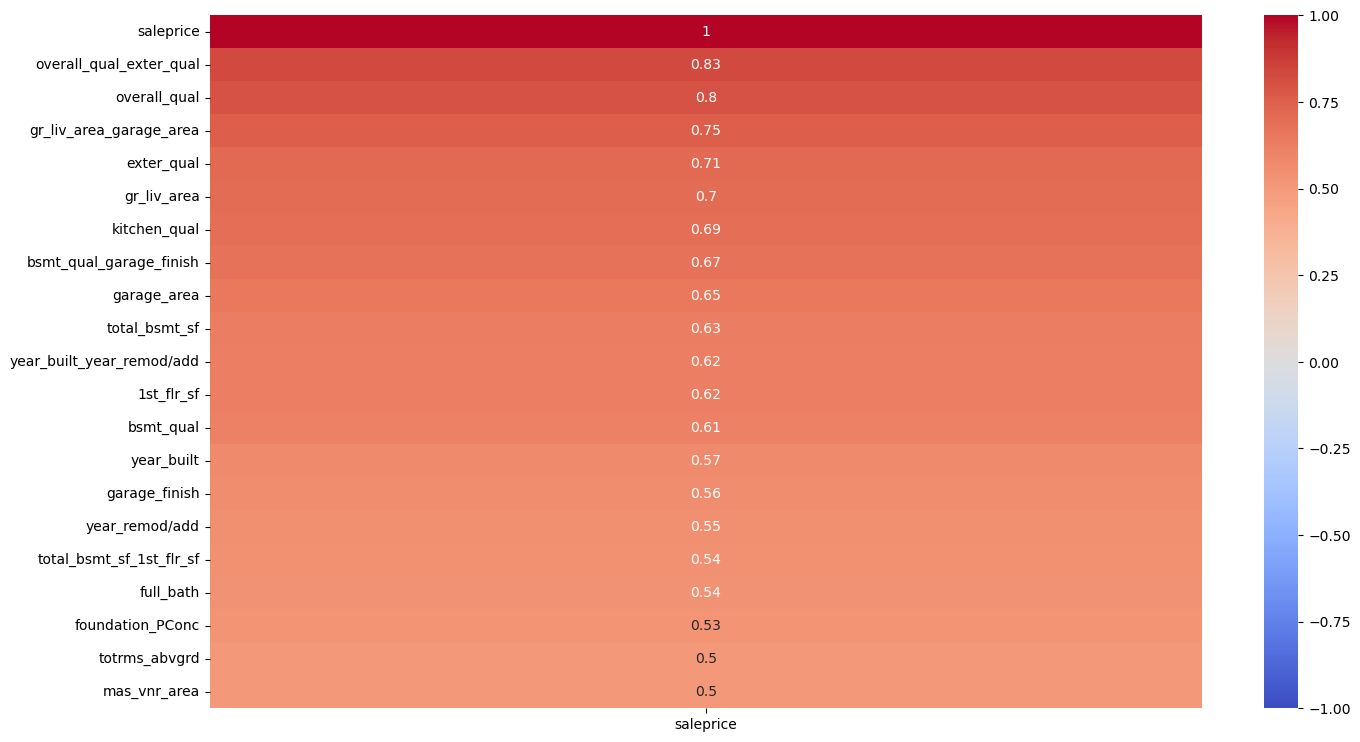

In [178]:
# Generate new heatmap with interaction terms
plt.figure(figsize=(16,9))
sns.heatmap(train_columns.corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
            annot=True,
            vmin=-1,
            vmax=1,
            cmap='coolwarm',)
plt.savefig('correlation_heatmap.png');

> New heatmap with interaction terms added

## Histogram and Pairplots

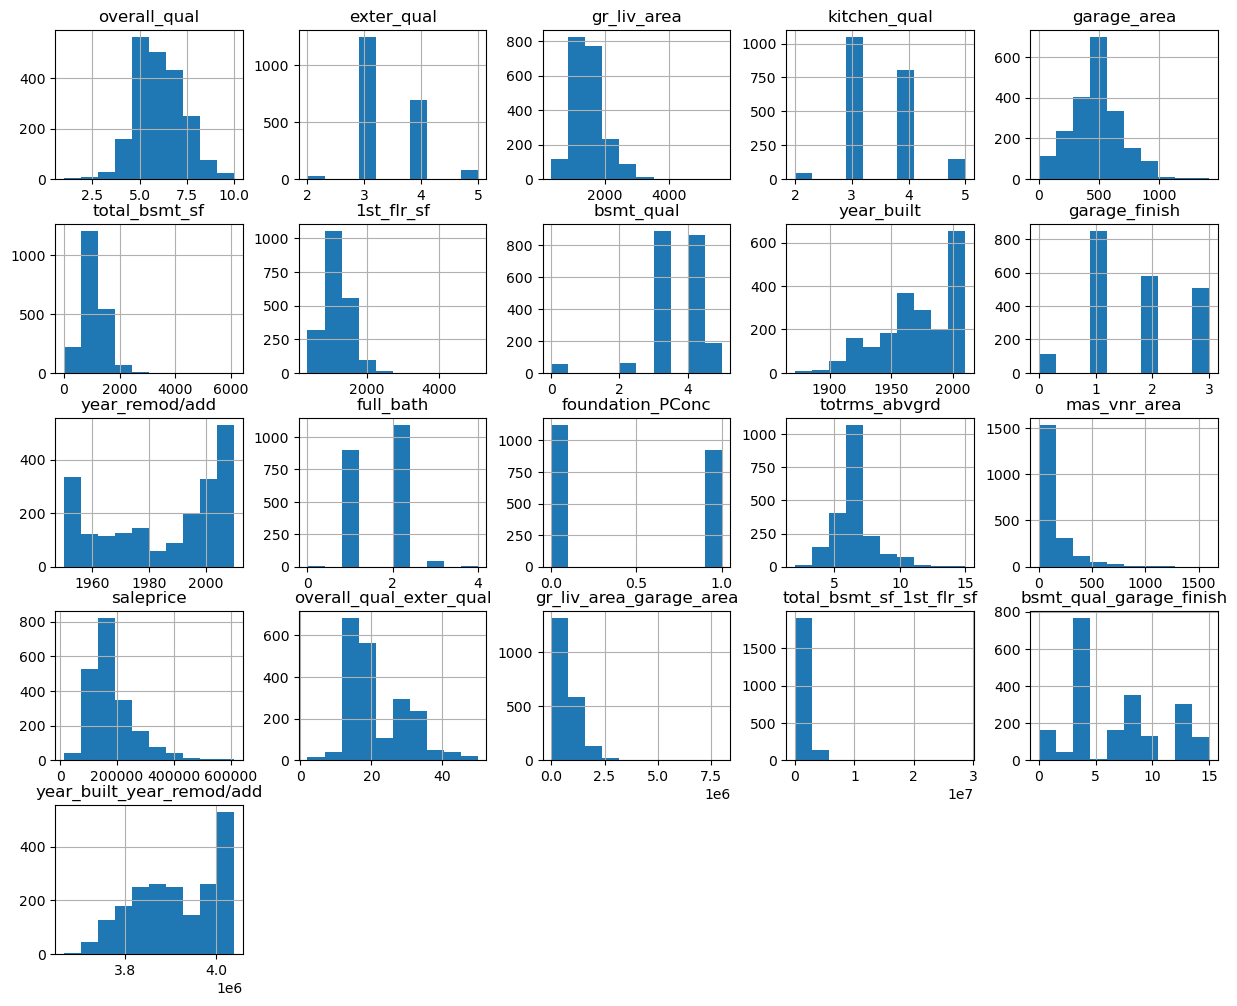

In [179]:
# Histogram created of each independent variable
train_columns.hist(figsize=(15, 12));

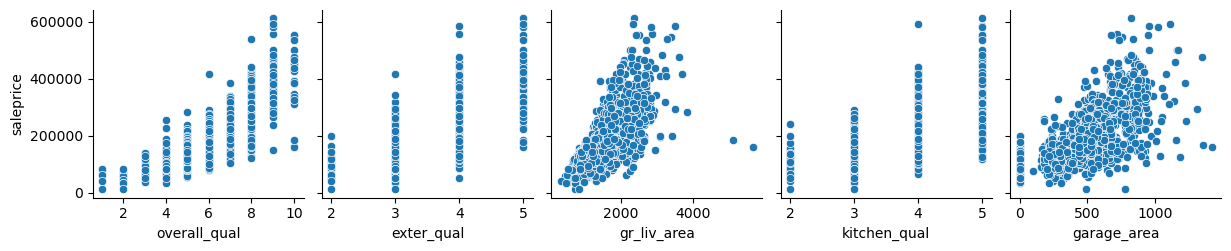

In [180]:
# Pairplots created to view the relationship between the independent variables and 'saleprice'
sns.pairplot(train_columns, x_vars=['overall_qual', 'exter_qual', 'gr_liv_area', 'kitchen_qual', 'garage_area'], y_vars=['saleprice']);

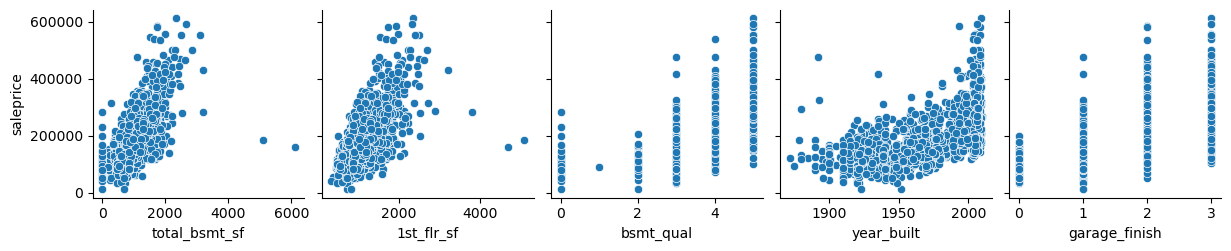

In [181]:
# Pairplots created to view the relationship between the independent variables and 'saleprice'
sns.pairplot(train_columns, x_vars=['total_bsmt_sf', '1st_flr_sf', 'bsmt_qual', 'year_built', 'garage_finish'], y_vars=['saleprice']);

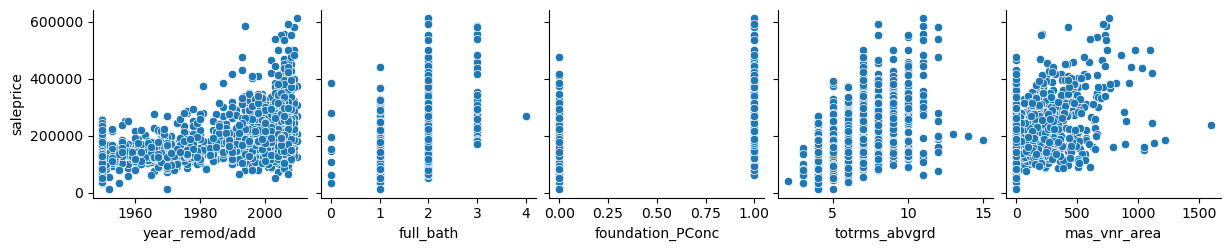

In [182]:
# Pairplots created to view the relationship between the independent variables and 'saleprice'
sns.pairplot(train_columns, x_vars=['year_remod/add', 'full_bath', 'foundation_PConc', 'totrms_abvgrd', 'mas_vnr_area'], y_vars=['saleprice']);

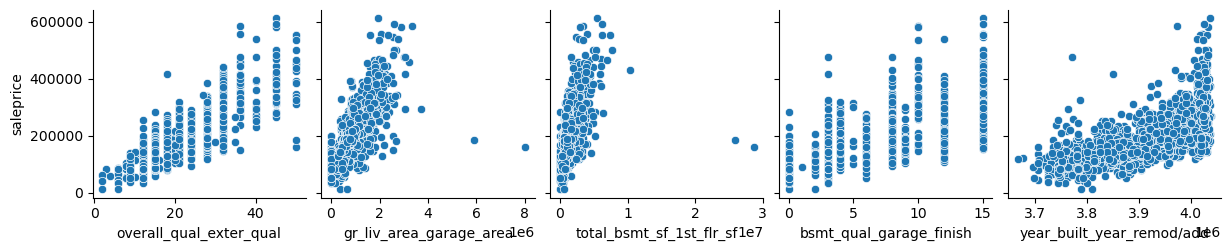

In [183]:
# Pairplots created to view the relationship between the independent variables and 'saleprice'
sns.pairplot(train_columns, x_vars=['overall_qual_exter_qual', 'gr_liv_area_garage_area', 'total_bsmt_sf_1st_flr_sf', 'bsmt_qual_garage_finish', 'year_built_year_remod/add'], y_vars=['saleprice']);

In [184]:
# Remove outliers from the pairplots

# Remove outlier from total_bsmt_sf to prevent heteroskedasticity
train_columns = train_columns[train_columns['total_bsmt_sf'] != 6110.0]
train_columns = train_columns[train_columns['total_bsmt_sf'] != 5095.0]

# Remove outlier from 1st_flr_sf to prevent heteroskedasticity
train_columns = train_columns[train_columns['1st_flr_sf'] != 5095]
train_columns = train_columns[train_columns['1st_flr_sf'] != 4692]

# Remove outlier from mas_vnr_area to prevent heteroskedasticity
train_columns = train_columns[train_columns['mas_vnr_area'] != 1600.0]

# Remove outlier from gr_liv_area_garage_area to prevent heteroskedasticity
train_columns = train_columns[train_columns['gr_liv_area_garage_area'] != 8000356.0]

# Remove outlier from total_bsmt_sf_1st_flr_sf to prevent heteroskedasticity
train_columns = train_columns[train_columns['total_bsmt_sf_1st_flr_sf'] != 28668120.0]
train_columns = train_columns[train_columns['total_bsmt_sf_1st_flr_sf'] != 25959025.0]
train_columns = train_columns[train_columns['total_bsmt_sf_1st_flr_sf'] != 10329600.0]

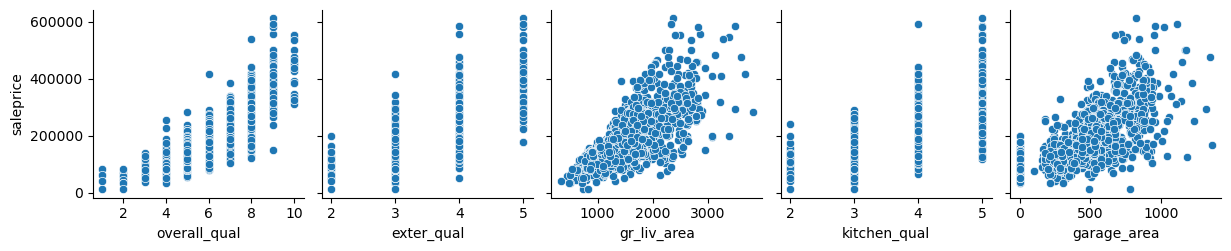

In [185]:
# Replot pairplots with outliers removed
sns.pairplot(train_columns, x_vars=['overall_qual', 'exter_qual', 'gr_liv_area', 'kitchen_qual', 'garage_area'], y_vars=['saleprice']);

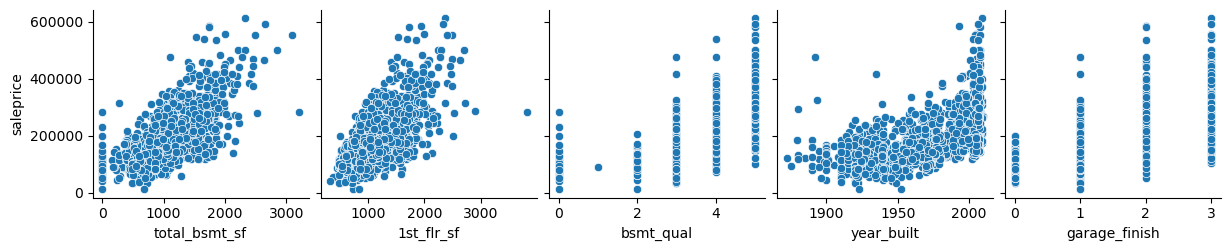

In [186]:
# Replot pairplots with outliers removed
sns.pairplot(train_columns, x_vars=['total_bsmt_sf', '1st_flr_sf', 'bsmt_qual', 'year_built', 'garage_finish'], y_vars=['saleprice']);

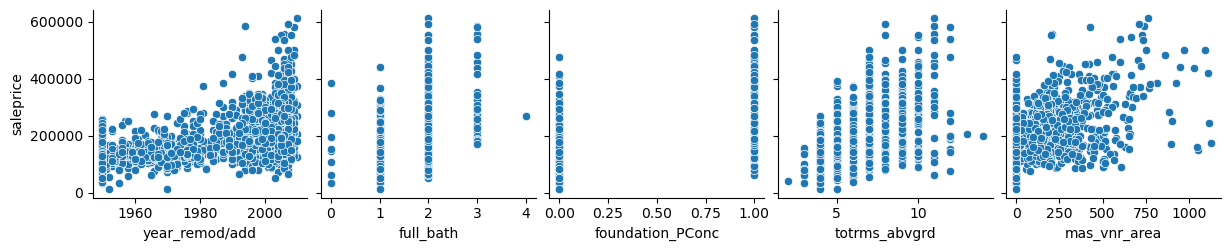

In [187]:
# Replot pairplots with outliers removed
sns.pairplot(train_columns, x_vars=['year_remod/add', 'full_bath', 'foundation_PConc', 'totrms_abvgrd', 'mas_vnr_area'], y_vars=['saleprice']);

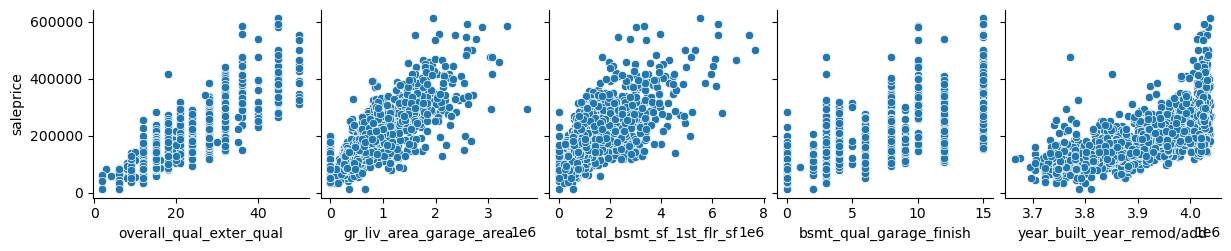

In [188]:
# Replot pairplots with outliers removed
sns.pairplot(train_columns, x_vars=['overall_qual_exter_qual', 'gr_liv_area_garage_area', 'total_bsmt_sf_1st_flr_sf', 'bsmt_qual_garage_finish', 'year_built_year_remod/add'], y_vars=['saleprice']);

# TTS and Fit Model

## Model Prep 

In [189]:
# Create X and y variables to fit on model
X = train_columns.drop('saleprice', axis=1)
y = train_columns['saleprice']

In [190]:
# Run TTS with random_state as year
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023)

In [191]:
# Scaling
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [192]:
# Instantiate and fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

## LINE Assumptions

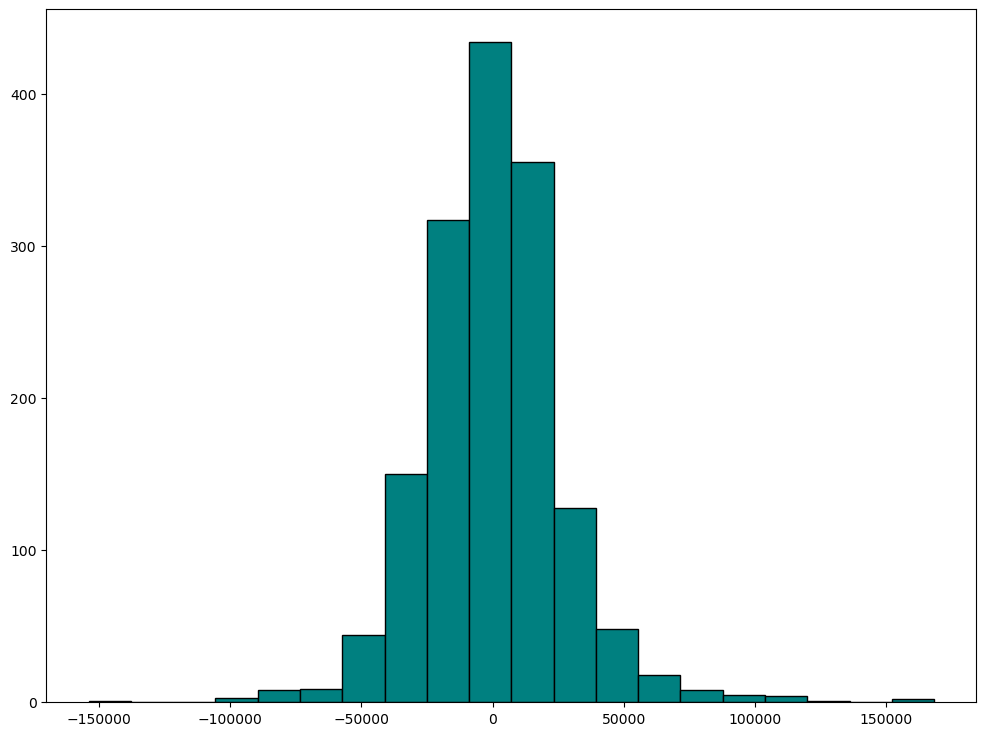

In [193]:
# N - Normality of errors
y_pred = lr.predict(X_train)
resids = y_train - y_pred

plt.figure(figsize=(12, 9))
plt.hist(resids, bins=20, color='teal', edgecolor='black')
plt.savefig('normal_dist.png');

> Histogram displays a normal distribution

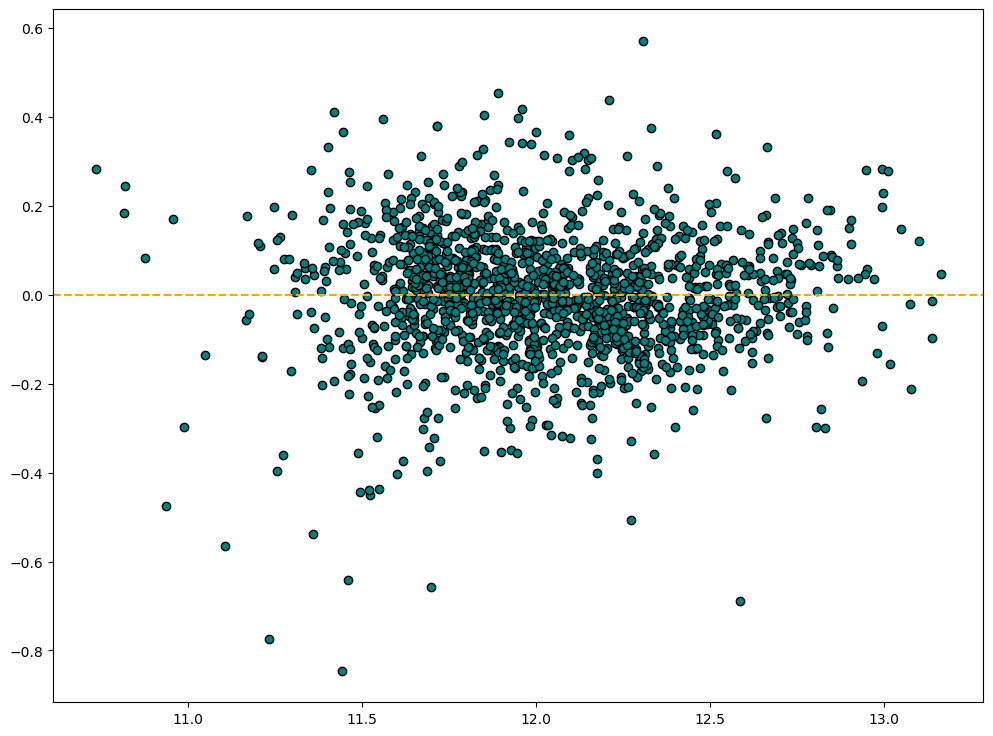

In [77]:
# E - Equal variance of errors
# Residual plot
plt.figure(figsize=(12,9))
plt.scatter(y_pred, resids, color='teal', edgecolor='black')
plt.axhline(0, color='orange', linestyle='--')
plt.savefig('homoscedastic.png');

> The equal variance of errors plot shows that it is homoskedastic. Dispersion of residuals is similar across the range of predicted values, assumptions of linear regression is met

# Score Model

In [81]:
# Using cross_val_score to find average R2 score with 10 folds
cross_val_score(lr, X_train, y_train, cv=10).mean()

0.8741436646350234

> Model correctly predicted the target variable for ~87.4% of the cases

In [82]:
# R2 score for train
print(f'Training R2 = {lr.score(X_train, y_train)}')

# R2 score for test
print(f'Testing R2 = {lr.score(X_test, y_test)}')

Training R2 = 0.8783574328318614
Testing R2 = 0.8404386238605019


> 84% of the variation in Sale Price can be explained by the independent variables

In [93]:
# Beta values for each independent variable
feature_names = ['overall_qual', 'exter_qual', 'gr_liv_area', 'kitchen_qual', 'garage_area',
                 'total_bsmt_sf', '1st_flr_sf', 'bsmt_qual', 'year_built', 'garage_finish',
                 'year_remod/add', 'full_bath', 'foundation_PConc', 'totrms_abvgrd',
                 'mas_vnr_area', 'saleprice', 'overall_qual_exter_qual',
                 'gr_liv_area_garage_area', 'total_bsmt_sf_1st_flr_sf',
                 'bsmt_qual_garage_finish']

independent_variable_coefs = pd.DataFrame({'Variable': feature_names, 'Coef': lr.coef_})
print(independent_variable_coefs)

                    Variable      Coef
0               overall_qual  0.157711
1                 exter_qual  0.062335
2                gr_liv_area  0.125845
3               kitchen_qual  0.030536
4                garage_area  0.030798
5              total_bsmt_sf  0.079868
6                 1st_flr_sf  0.057236
7                  bsmt_qual  0.015687
8                 year_built  3.198733
9              garage_finish  0.019463
10            year_remod/add  2.130358
11                 full_bath -0.020417
12          foundation_PConc  0.009374
13             totrms_abvgrd -0.010307
14              mas_vnr_area  0.005636
15                 saleprice -0.098556
16   overall_qual_exter_qual  0.023408
17   gr_liv_area_garage_area -0.058000
18  total_bsmt_sf_1st_flr_sf  0.013816
19   bsmt_qual_garage_finish -4.749496


> Positive coefficients (> 0) represents an increase in the predicted saleprice, assuming all other factors remain constant. Negative coefficients represent a decrease in predicted saleprice

In [94]:
print(lr.intercept_)

12.030392782876723


> When the Sale Price of a home is zero, the price will be $12.03

## Statsmodel Library

In [95]:
X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     670.8
Date:                Mon, 05 Jun 2023   Prob (F-statistic):               0.00
Time:                        03:09:35   Log-Likelihood:                 994.85
No. Observations:                2044   AIC:                            -1948.
Df Residuals:                    2023   BIC:                            -1830.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      -166.8398     29.830     -5.593      0.000    -225.340    -108.340
overall_qual                  0.4825      0.206      2.337      0.020       0.078       0.887
exter_qual                    0.0349      0.059      0.593      0.553      -0.080       0.150
gr_liv_area                   0.0002   2.35e-05     10.332      0.000       0.000       0.000
kitchen_qual                  0.0503      0.008      6.196      0.000       0.034       0.066
garage_area                   0.0001   5.13e-05      2.043      0.041     4.2e-06       0.000
total_bsmt_sf                 0.0002   3.11e-05      6.062      0.000       0.000       0.000
1st_flr_sf                    0.0001   2.37e-05      5.869      0.000    9.27e-05       0.000
bsmt_qual                     0.0184      0.010      1.853      0.064      -0.001       0.038
year_built                    0.0891      0.015      5.809      0.000       0.059       0.119
garage_finish                 0.0200      0.018      1.082      0.279      -0.016       0.056
year_remod/add                0.0877      0.015      5.838      0.000       0.058       0.117
full_bath                    -0.0345      0.009     -3.858      0.000      -0.052      -0.017
foundation_PConc              0.0154      0.011      1.387      0.166      -0.006       0.037
totrms_abvgrd                -0.0021      0.004     -0.558      0.577      -0.010       0.005
mas_vnr_area               4.484e-05    2.4e-05      1.871      0.062   -2.17e-06    9.19e-05
overall_qual_exter_qual      -0.0321      0.203     -0.158      0.874      -0.430       0.366
gr_liv_area_garage_area    4.659e-08   3.05e-08      1.529      0.126   -1.32e-08    1.06e-07
total_bsmt_sf_1st_flr_sf   -5.15e-08   1.71e-08     -3.017      0.003    -8.5e-08    -1.8e-08
bsmt_qual_garage_finish       0.0030      0.005      0.599      0.549      -0.007       0.013
year_built_year_remod/add -4.414e-05   7.73e-06     -5.714      0.000   -5.93e-05    -2.9e-05
==============================================================================
Omnibus:                      841.476   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13716.728
Skew:                          -1.500   Prob(JB):                         0.00
Kurtosis:                      15.331   Cond. No.                     3.81e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.81e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Ridge and LASSO Model

## Polynomial Features

In [98]:
# Create X and y
X = train_columns.drop('saleprice', axis=1)
y = train_columns['saleprice']

# Instatiate our Polynomial Features object to create all two-way terms
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and Transform our X data
X_overfit = poly.fit_transform(X)

In [99]:
poly.get_feature_names_out(X.columns)

array(['overall_qual', 'exter_qual', 'gr_liv_area', 'kitchen_qual',
       'garage_area', 'total_bsmt_sf', '1st_flr_sf', 'bsmt_qual',
       'year_built', 'garage_finish', 'year_remod/add', 'full_bath',
       'foundation_PConc', 'totrms_abvgrd', 'mas_vnr_area',
       'overall_qual_exter_qual', 'gr_liv_area_garage_area',
       'total_bsmt_sf_1st_flr_sf', 'bsmt_qual_garage_finish',
       'year_built_year_remod/add', 'overall_qual^2',
       'overall_qual exter_qual', 'overall_qual gr_liv_area',
       'overall_qual kitchen_qual', 'overall_qual garage_area',
       'overall_qual total_bsmt_sf', 'overall_qual 1st_flr_sf',
       'overall_qual bsmt_qual', 'overall_qual year_built',
       'overall_qual garage_finish', 'overall_qual year_remod/add',
       'overall_qual full_bath', 'overall_qual foundation_PConc',
       'overall_qual totrms_abvgrd', 'overall_qual mas_vnr_area',
       'overall_qual overall_qual_exter_qual',
       'overall_qual gr_liv_area_garage_area',
       'overall_

In [100]:
# Check out the dimensions of X_overfit
X_overfit.shape

(2044, 230)

In [110]:
# Create train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X_overfit,
    y,
    test_size=0.7,
    random_state=2023
)

In [111]:
# Scale our data
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

## OLS

In [112]:
# Instatiate and fit
ols = LinearRegression()
ols.fit(Z_train, y_train)

LinearRegression()

In [113]:
# R2 score for train and test
print(f'Training R2: {ols.score(Z_train, y_train)}')
print(f'Testing R2: {ols.score(Z_test, y_test)}')                      

Training R2: 0.9408547606715018
Testing R2: 0.24389998382639566


- The Training R2 shows that the polynomial regression explains ~94% of the variance in Sale Price
- The Testing R2 shows that the polynomial regression explains ~24% of the variance in unseen data, which is poor
- Polynomial Regression model is overfitting the training data, overly complex

In [127]:
ols.coef_

array([ 2.33475665e+09,  8.08531951e+09, -4.96283318e+02,  1.23517290e+02,
        8.94582396e+01, -1.78018825e+02, -4.34300488e+02,  1.27928365e+02,
       -1.18959194e+04,  2.30711976e+02, -8.65754255e+03,  1.52677934e+02,
        4.91196741e+01,  1.55994294e+02,  1.16443072e+02, -3.66738000e+09,
        6.51763469e+01,  2.49092773e+02, -1.03105343e+02,  1.83683954e+04,
       -1.57430605e+09,  9.22560209e+09,  2.67461008e+01, -1.36186314e+01,
        2.28784537e+01, -2.44857192e+01, -3.32625946e+01, -1.22940018e+01,
       -5.04556229e+03, -1.94797733e+01, -5.10407676e+03,  2.16225350e+00,
       -1.74691993e+00,  6.77604795e-01, -1.74447519e+00,  5.17968589e+09,
       -3.36506155e+01,  3.91185153e+01,  1.71178962e+01,  5.39909367e+03,
        1.27007134e+09,  1.59877124e+01, -8.74337375e+00,  1.40932508e+01,
       -1.37230376e+01, -1.88537096e+01, -7.52400041e+00, -2.99478006e+03,
       -1.17659548e+01, -3.05827093e+03,  9.47272539e-01, -1.02263188e+00,
        1.08404160e-01, -

In [128]:
ols.intercept_

12.037526270159788

## RidgeCV

In [117]:
# Instatiate
ridge_model = Ridge(alpha=10)

# Set up a list of ridge alphas to check
r_alphas = np.logspace(0, 5, 100)

# Cross-validate over our list of ridge alphas
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=10)

# Fit model using best ridge alpha
ridge_cv = ridge_model.fit(Z_train, y_train)

In [118]:
# Optimal value of alpha
ridge_cv.alpha

10

In [119]:
print(f'Train ridge R2 score: {ridge_cv.score(Z_train, y_train)}')
print(f'Test ridge R2 score: {ridge_cv.score(Z_test, y_test)}')

Train ridge R2 score: 0.8946575030329238
Test ridge R2 score: 0.8578776308712506


- Train R2 score explains ~89.5% of the variance in the sale price
- Test R2 score explains ~85.8% of the variance in the sale price
- Ridge Regression Model is not overfitting and is robust and reliable in making predictions

In [129]:
ridge_cv.coef_

array([ 0.01210417, -0.00721309,  0.01673491, -0.01433881,  0.01056358,
        0.0132144 ,  0.02573469,  0.00312611,  0.01751645,  0.01661279,
        0.00996889,  0.0006102 ,  0.02037425,  0.00522107, -0.00389501,
        0.01790524, -0.00358358, -0.0123094 , -0.00089096,  0.01077486,
        0.01580429,  0.00650768,  0.00533987,  0.00731574,  0.00216411,
        0.01164285, -0.00635343,  0.0003896 ,  0.00170977, -0.01243218,
        0.00814814, -0.02126025, -0.00570577,  0.02014261, -0.0077848 ,
        0.01602048,  0.0019098 , -0.004562  , -0.01936529, -0.00227092,
       -0.01563332,  0.032854  ,  0.00533896,  0.006476  ,  0.01084435,
        0.026254  , -0.013293  , -0.0145118 ,  0.01892854, -0.00902167,
       -0.00414542, -0.03380165,  0.00088404,  0.02283231, -0.00291191,
        0.00622722,  0.00480785,  0.00582274, -0.01645728, -0.00797002,
        0.03963563, -0.00358358,  0.00559822, -0.02130623,  0.02002443,
        0.00992787,  0.01440311,  0.02168608,  0.00267624,  0.01

In [130]:
ridge_cv.intercept_

12.037331129447091

## LassoCV

In [122]:
# Set up a list of lasso alphas to check
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of lass alphas
lasso_cv = LassoCV(alphas=l_alphas, cv=10, max_iter=50_000)

# Fit model using best ridge alpha
lasso_cv.fit(Z_train, y_train)

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]),
        cv=10, max_iter=50000)

In [123]:
# Optimal value of alpha
lasso_cv.alpha_

0.001

In [124]:
print(f'Train lasso R2 score: {lasso_cv.score(Z_train, y_train)}')
print(f'Test lasso R2 score: {lasso_cv.score(Z_test, y_test)}')

Train lasso R2 score: 0.8856559591330742
Test lasso R2 score: 0.8571961222407677


- Train R2 score explains ~88.5% of the variance in the sale price
- Test R2 score explains ~85.7% of the variance in the sale price
- Lasso Regression Model is not overfitting and is robust and reliable in making predictions

In [131]:
lasso_cv.coef_

array([ 0.0675213 , -0.        ,  0.        , -0.        ,  0.02126591,
        0.        ,  0.        , -0.        ,  0.00204128,  0.0427302 ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.04769405,
        0.0186318 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.00990115, -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.03332828, -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.03649182,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.07690078,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.04359085,  0.        ,  0.  

In [132]:
lasso_cv.intercept_

12.037331129447091

# Visualizations

In [135]:
train_no_dummy = pd.read_csv('./clean_datasets/finish_clean_training.csv')

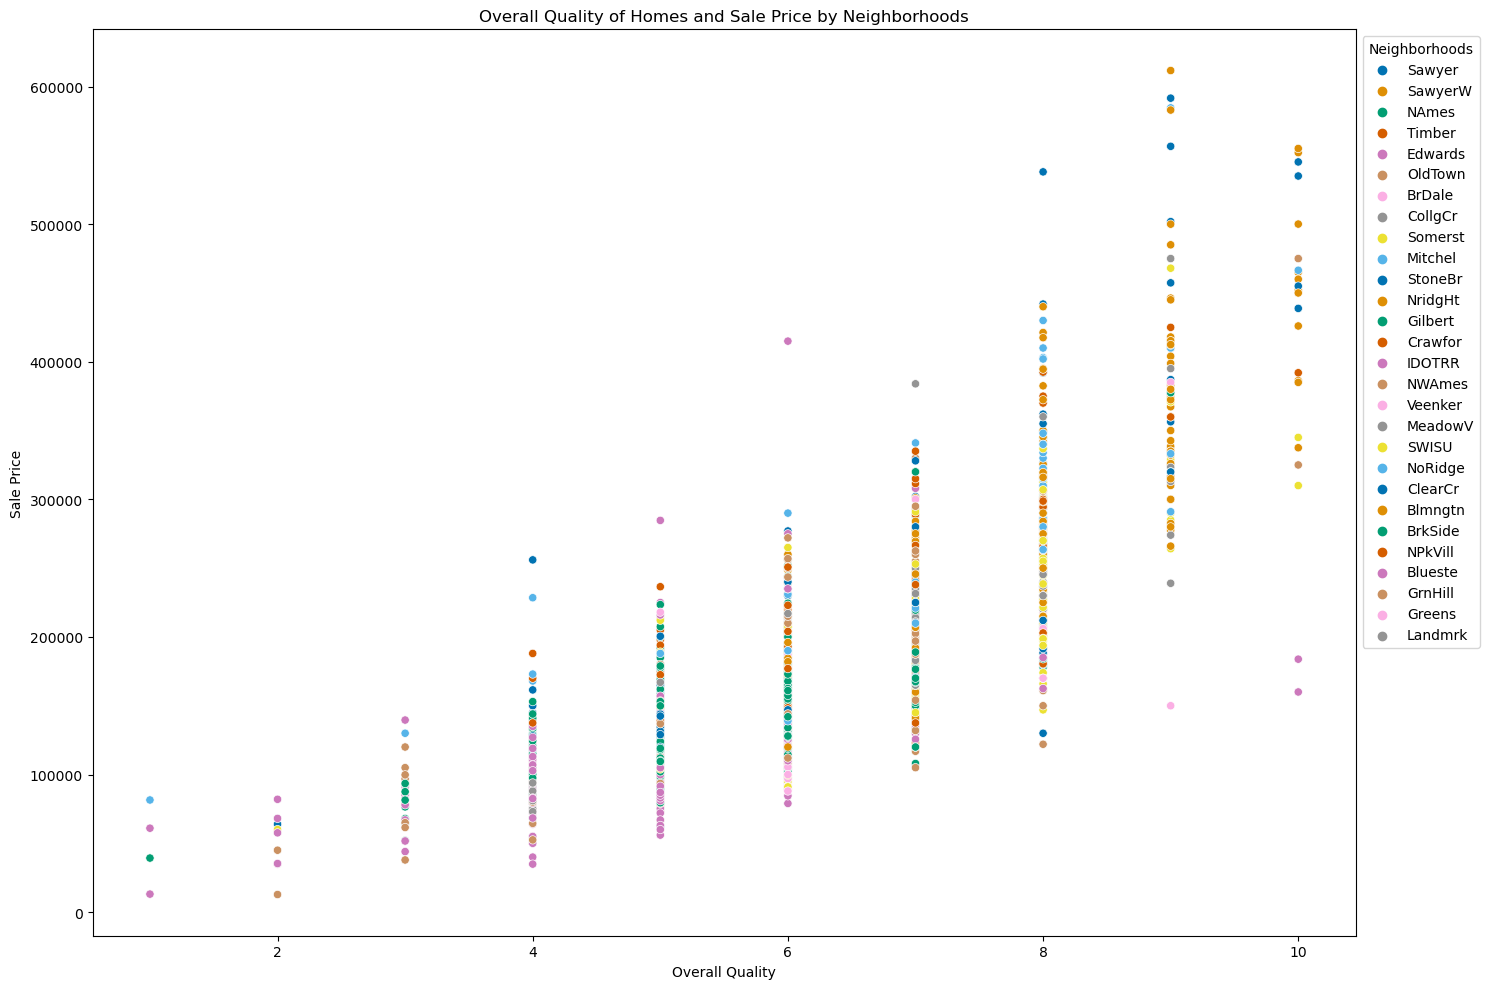

In [138]:
# Scatterplot - Overall Quality x Sale Price x Neighborhood
plt.figure(figsize=(15,10))
# Plot
sns.scatterplot(x='overall_qual', y='saleprice', hue='neighborhood', data=train_no_dummy, palette='colorblind')
# Title
plt.title('Overall Quality of Homes and Sale Price by Neighborhoods')
# Set X and Y
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
#Legend
plt.legend(title='Neighborhoods', bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout();

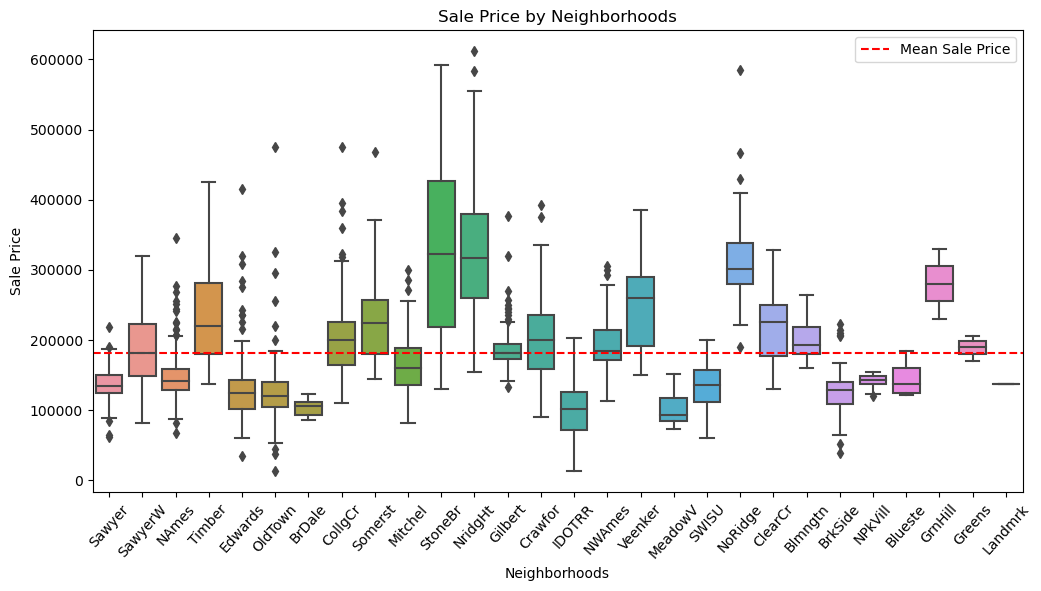

In [161]:
# Boxplot - Neighborhood x Sale Price
plt.figure(figsize=(12,6))
sns.boxplot(x='neighborhood', y='saleprice', data=train_no_dummy)
# Descriptive title for first plot
plt.title('Sale Price by Neighborhoods')
# X and Y labels for first plot
plt.xlabel('Neighborhoods')
plt.ylabel('Sale Price')
plt.xticks(rotation=48)

# Calculate the mean sale price
mean_sale_price = train_no_dummy['saleprice'].mean()
plt.axhline(mean_sale_price, color='red', linestyle='--', label='Mean Sale Price')
plt.legend()
plt.savefig('sale_neighborhood.png');

> Included the mean sale price which is around $181,146

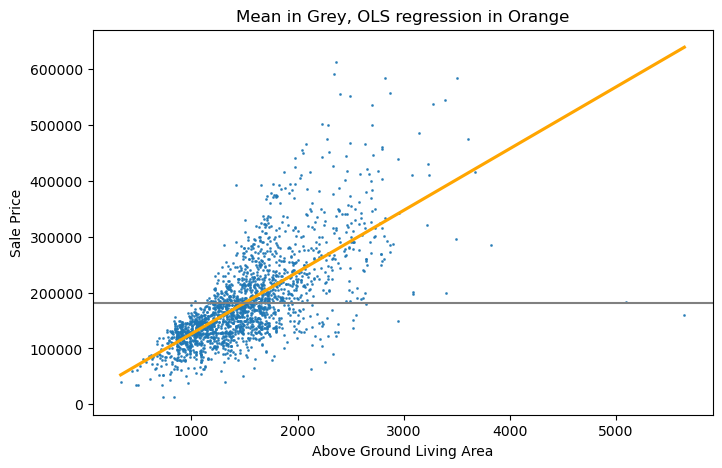

In [148]:
# Regplot - Above Ground Living Area x Sale Price
plt.figure(figsize=(8,5))
sns.regplot(x='gr_liv_area', y='saleprice', data=train_no_dummy, ci=None,
           scatter_kws={'s': 1},
           line_kws={'color': 'orange'})
plt.axhline(train_no_dummy['saleprice'].mean(), color='grey')
plt.xlabel('Above Ground Living Area')
plt.ylabel('Sale Price')
plt.title('Mean in Grey, OLS regression in Orange');

> Positive OLS regression for gr_liv_area and saleprice

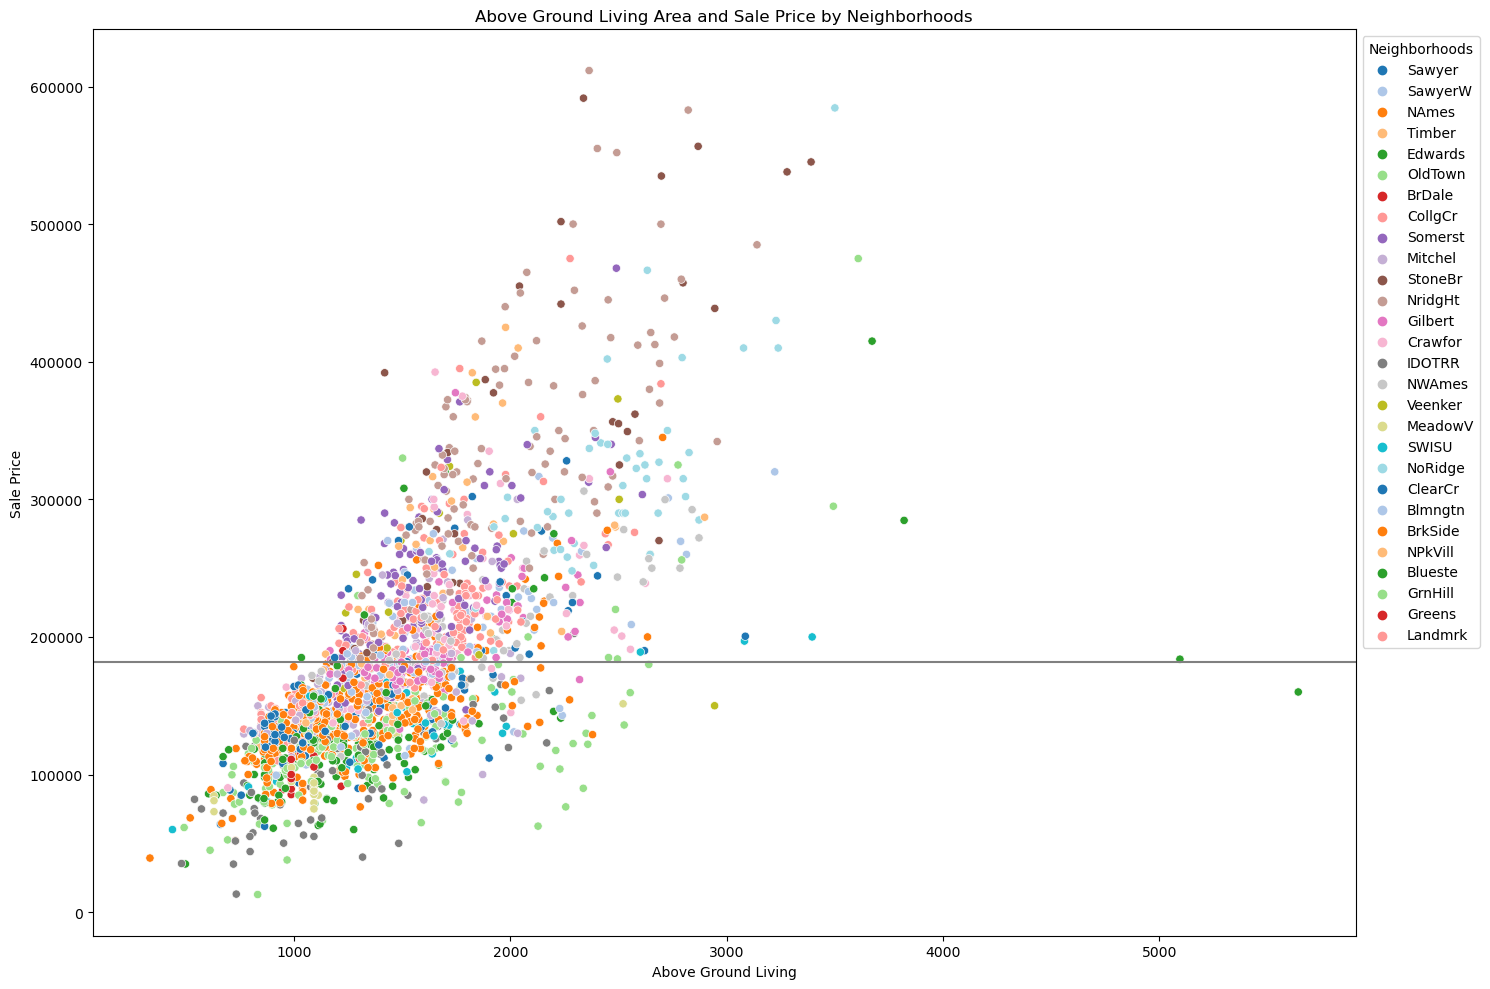

In [160]:
# Scatter - Above Ground Living Area x Sale Price x Neighborhood
plt.figure(figsize=(15,10))
# Define a custom color palette with enough unique colors
custom_palette = sns.color_palette('tab20', n_colors=len(train_no_dummy['neighborhood'].unique()))
# Plot
sns.scatterplot(x='gr_liv_area', y='saleprice', hue='neighborhood', data=train_no_dummy, palette=custom_palette)
# Title
plt.title('Above Ground Living Area and Sale Price by Neighborhoods')
# Set X and Y
plt.xlabel('Above Ground Living')
plt.ylabel('Sale Price')
plt.axhline(train_no_dummy['saleprice'].mean(), color='grey')
#Legend
plt.legend(title='Neighborhoods', bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout()
plt.savefig('gr_liv_area_sale_neighborhood.png');

> Many of the neighborhoods are < 3,000 above ground and fall around 1000-2000

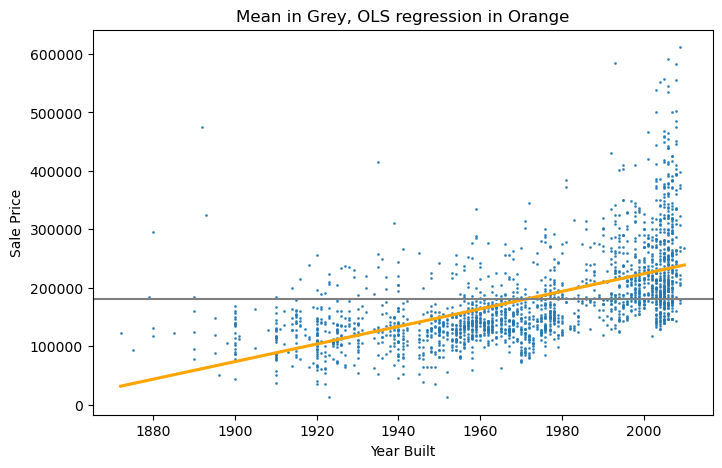

In [150]:
# Regplot - Year Built x Sale Price
plt.figure(figsize=(8,5))
sns.regplot(x='year_built', y='saleprice', data=train_no_dummy, ci=None,
           scatter_kws={'s': 1},
           line_kws={'color': 'orange'})
plt.axhline(train_no_dummy['saleprice'].mean(), color='grey')
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.title('Mean in Grey, OLS regression in Orange');

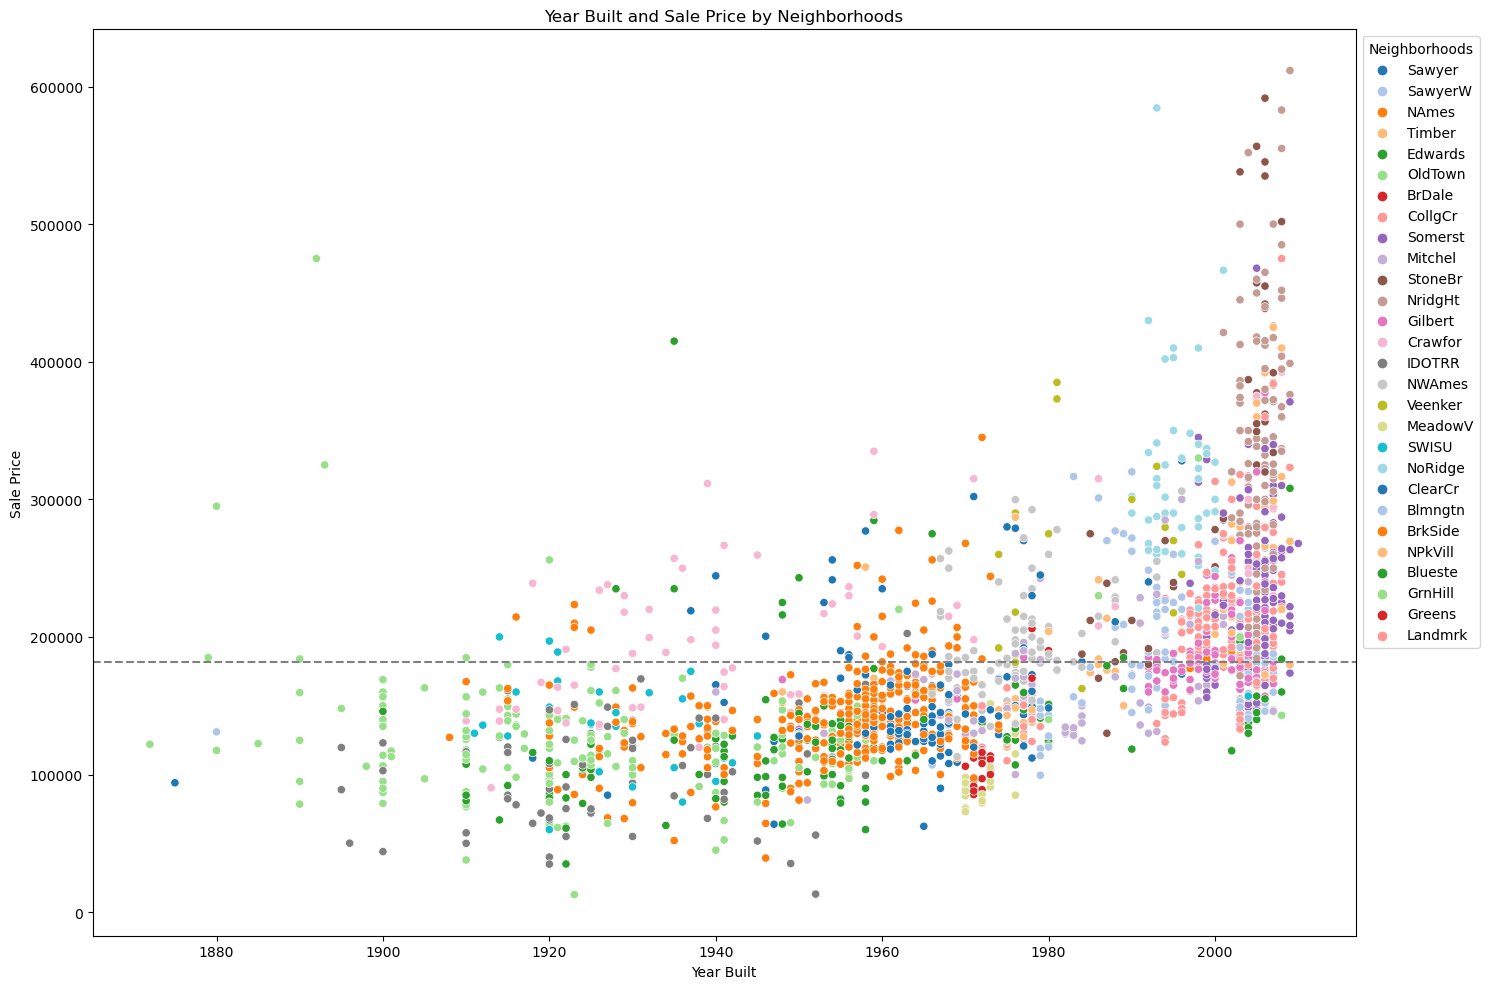

In [159]:
# Scatter - Year Built x Sale Price x Neighborhood
plt.figure(figsize=(15,10))
# Define a custom color palette with enough unique colors
custom_palette = sns.color_palette('tab20', n_colors=len(train_no_dummy['neighborhood'].unique()))
# Plot
sns.scatterplot(x='year_built', y='saleprice', hue='neighborhood', data=train_no_dummy, palette=custom_palette)
# Title
plt.title('Year Built and Sale Price by Neighborhoods')
# Set X and Y
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.axhline(train_no_dummy['saleprice'].mean(), color='grey', linestyle='--')
#Legend
plt.legend(title='Neighborhoods', bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout()
plt.savefig('yearbuilt_sale_neighborhood.png');

> Somerset (purple), Stone Brooke (Dark Brown), Northridge height (Light brown), are generally more expensive and are on the north side of ames (developing)

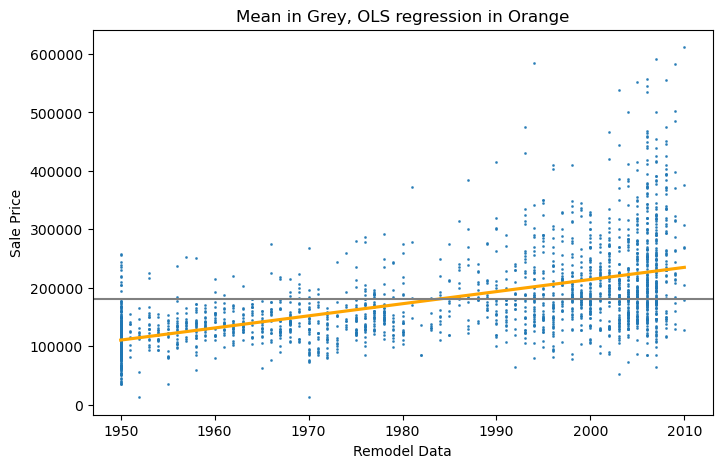

In [152]:
# Regplot - Remodel Date x Sale Price
plt.figure(figsize=(8,5))
sns.regplot(x='year_remod/add', y='saleprice', data=train_no_dummy, ci=None,
           scatter_kws={'s': 1},
           line_kws={'color': 'orange'})
plt.axhline(train_no_dummy['saleprice'].mean(), color='grey')
plt.xlabel('Remodel Date')
plt.ylabel('Sale Price')
plt.title('Mean in Grey, OLS regression in Orange');

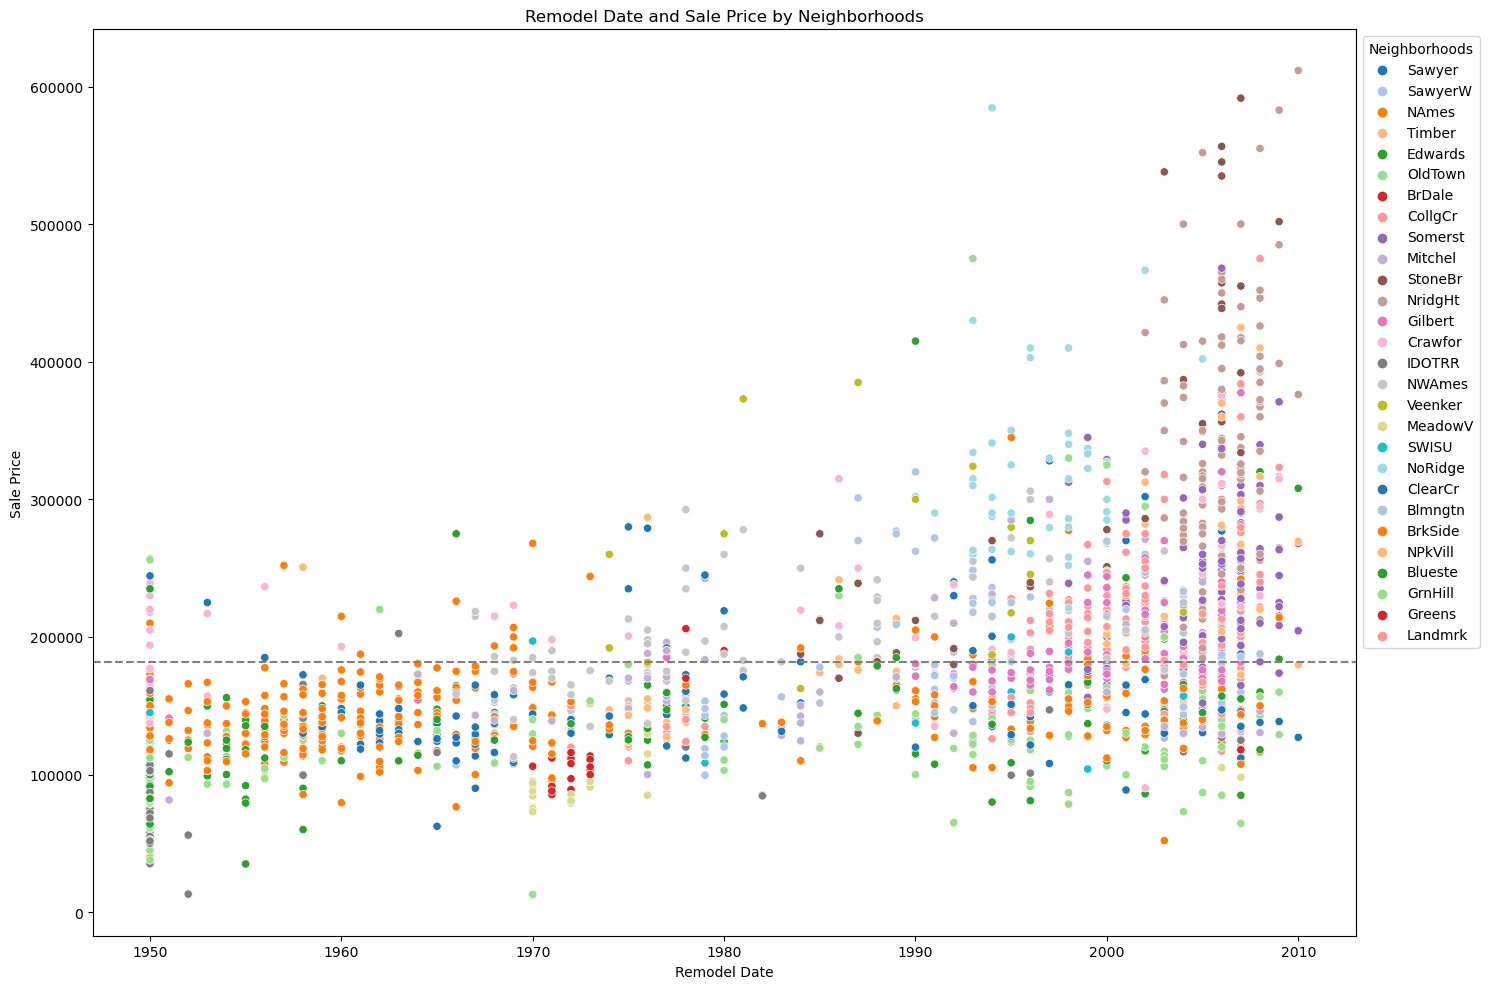

In [158]:
# Scatter - Remodel Date x Sale Price x Neighborhood
plt.figure(figsize=(15,10))
# Define a custom color palette with enough unique colors
custom_palette = sns.color_palette('tab20', n_colors=len(train_no_dummy['neighborhood'].unique()))
# Plot
sns.scatterplot(x='year_remod/add', y='saleprice', hue='neighborhood', data=train_no_dummy, palette=custom_palette)
# Title
plt.title('Remodel Date and Sale Price by Neighborhoods')
# Set X and Y
plt.xlabel('Remodel Date')
plt.ylabel('Sale Price')
plt.axhline(train_no_dummy['saleprice'].mean(), color='grey', linestyle='--')
#Legend
plt.legend(title='Neighborhoods', bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout()
plt.savefig('remodel_sale_neighborhood.png');

> As newer houses get remodeled and built (north of ames), price increases